## Library installation

In [1]:
# Libraries to import
import pandas as pd
import yfinance as yfinance
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import numpy as np
import time

## Data Initialisation (Cleaning)

In [2]:
# Scrapigng the data for stock prices
import yfinance as yf
import pandas as pd
tickers = ["^GSPC", 'NDAQ']
start_date = "2020-01-01"
end_date = "2025-04-17"

data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv('/Users/ivan/Documents/Data Science Projects/spx_price_forecast/Datasets/dataframe.csv')
df = pd.read_csv('/Users/ivan/Documents/Data Science Projects/spx_price_forecast/Datasets/dataframe.csv')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [3]:
# Cleaning the data 
df.drop(["Close", "High", "Volume", "Low", "Close.1", "High.1", "Low.1", "Volume.1"], axis=1, inplace=True)

In [4]:
df.head()

,Price,Open,Open.1
0,Ticker,NDAQ,^GSPC
1,Date,NaN,NaN
2,2020-01-02,33.15273381526384,3244.669921875
3,2020-01-03,33.06619884851803,3226.360107421875
4,2020-01-06,33.31654914420584,3217.550048828125


In [5]:
# Cleaning rows and columns
df.columns = ["Date", "NDAQ", "SPX"]  
df = df[df["Date"] != "NaN"]  

df = df.drop([0, 1])  
df = df.reset_index(drop=True)

df = df.round(2)

df['SPX'] = pd.to_numeric(df['SPX'], errors='coerce')
df['NDAQ'] = pd.to_numeric(df['NDAQ'], errors='coerce')

In [6]:
# Time-series set date variable
df["Date"] = pd.to_datetime(df["Date"])  
df.set_index("Date", inplace=True)  

In [7]:
import time
if isinstance(df.index, pd.DatetimeIndex):
    print("Time Series has been set")
else:
    print("Time Series has not been set yet")
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    time.sleep(3)
    print("It has been done now!")    

Time Series has been set


In [8]:
df.head()

,NDAQ,SPX
Date,,
2020-01-02,33.152734,3244.669922
2020-01-03,33.066199,3226.360107
2020-01-06,33.316549,3217.550049
2020-01-07,33.381469,3241.860107
2020-01-08,32.920921,3238.590088


In [9]:
df.describe()

,NDAQ,SPX
count,1330.000000,1330.000000
mean,54.528454,4342.437904
std,12.123234,826.635154
min,23.884959,2290.709961
25%,47.305538,3840.292542
50%,55.046449,4268.474854
75%,61.006667,4741.230103
max,83.720662,6134.500000


In [10]:
# Segregating dataset into the training and testing model. We have decided to go for a (70:30 split)
# df = training set
# df_test = testing set
size = int(len(df)*0.7)
df, df_test = df.iloc[:size], df.iloc[size:] 
#df = training set and has 70% of the data, 
#df_test = testing set and has 30% of the data

In [11]:
df.describe()

,NDAQ,SPX
count,930.000000,930.000000
mean,50.086225,3926.816941
std,9.793460,523.046527
min,23.884959,2290.709961
25%,40.852162,3633.654968
50%,51.362895,4001.204956
75%,57.811201,4356.089844
max,67.901724,4804.509766


In [12]:
df_test.describe()

,NDAQ,SPX
count,400.000000,400.000000
mean,64.856637,5308.756643
std,10.643945,548.016424
min,46.381457,4139.390137
25%,55.948165,4952.882568
50%,61.678094,5355.474854
75%,74.234207,5758.852539
max,83.720662,6134.500000


## Visualising data and preparing for training phase

In [13]:
df["SPX"].describe()

count     930.000000
mean     3926.816941
std       523.046527
min      2290.709961
25%      3633.654968
50%      4001.204956
75%      4356.089844
max      4804.509766
Name: SPX, dtype: float64

Text(0.5, 1.0, 'SPX Prices')

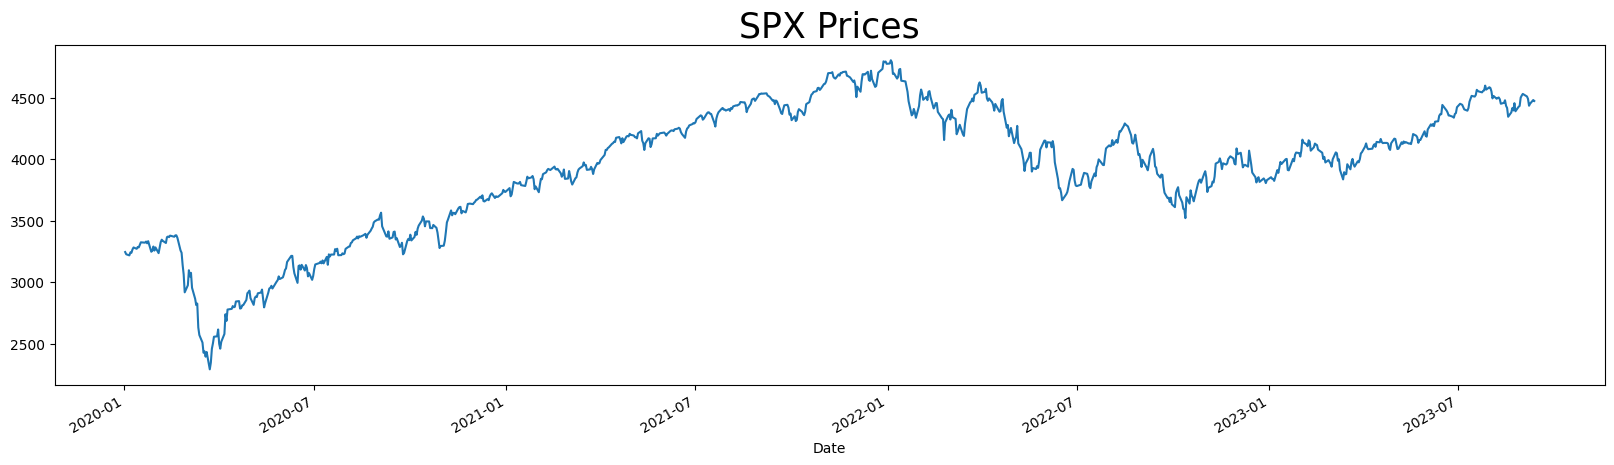

In [14]:
# Plotting the data
import matplotlib.pyplot as plt
df["SPX"].plot(figsize=(20,5))
plt.title("SPX Prices", size = 25)

### Testing for Stationarity 

In [15]:
# Dickey-Fuller Test
import statsmodels.tsa.stattools as sts
adf_result = sts.adfuller(df.SPX)

adf_pvalue = adf_result[1]

print(adf_result)
print(f'p-value from ADF test = {adf_pvalue}')

(-1.4986175702522344, 0.5341950959548422, 1, 928, {'1%': -3.4374162506455126, '5%': -2.8646595140022946, '10%': -2.568431020409111}, 9478.72621660242)
p-value from ADF test = 0.5341950959548422


In [16]:
print(f'We find the p-value = {adf_result[1]}')
# Since the p-value is greater than 0.05, we cannot reject H0, and therefore SPX is not stationary in levels form

We find the p-value = 0.5341950959548422


In [17]:
df['d.SPX'] = df.SPX.diff(1)
df= df.dropna()
df.head()

,NDAQ,SPX,d.SPX
Date,,,
2020-01-03,33.066199,3226.360107,-18.309814
2020-01-06,33.316549,3217.550049,-8.810059
2020-01-07,33.381469,3241.860107,24.310059
2020-01-08,32.920921,3238.590088,-3.270020
2020-01-09,32.846738,3266.030029,27.439941


Text(0.5, 1.0, 'S&P 500 Prices (First Difference)')

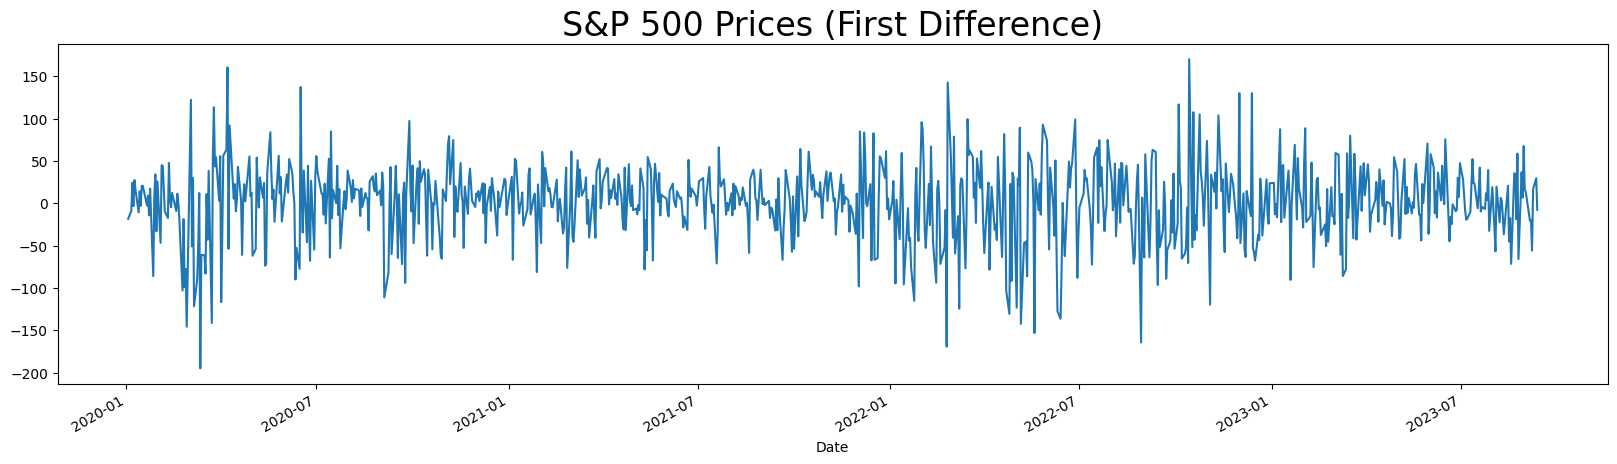

In [18]:
df['d.SPX'].plot(figsize=(20,5))
plt.title("S&P 500 Prices (First Difference)", size=24) 

Here, we see that when the S&P 500 has been differenced once, our plot already look stationary. To confirm, we should run the ADF test again.

In [19]:
adf_result2 = sts.adfuller(df['d.SPX'])
print(f'We find the p-value = {adf_result2[1]}')
# Since the p-value is less than 0.05, we can reject H0, and therefore SPX is stationary in first-diff (I=1) form

We find the p-value = 0.0


We see that the p-value < 0.05, so (via. the ADF test) we find that prices are now stationary (in first difference form).

### Identifying Optimal AR and MA lags

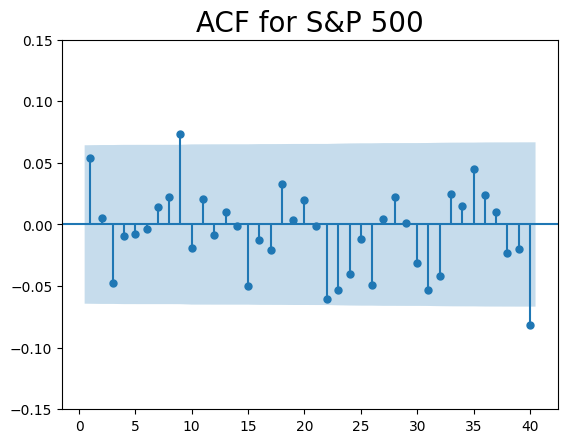

(-0.15, 0.15)

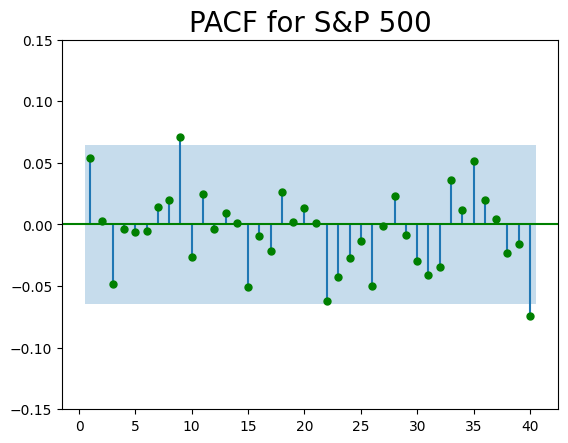

In [20]:
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt

# Plot the ACF for first difference S&P 500
price_acf = sgt.plot_acf(df['d.SPX'], zero=False, lags=40)
plt.title("ACF for S&P 500", size=20)
plt.gca().set_ylim(-0.15, 0.15)
plt.show()

# Plot PACF for first difference S&P 500
price_pacf = sgt.plot_pacf(df['d.SPX'], zero = False, lags = 40, color = "green")
plt.title("PACF for S&P 500", size = 20)
plt.gca().set_ylim(-0.15, 0.15)

# From visually looking, we find that an AR(9) model seems to be the most optimal lag... report will go into more detail about this.

### Fitting the Model

In [ ]:
import pmdarima as pm
# Define the maximum number of lags to consider
max_lags = 10

# Function to find the best ARIMA order using different information criteria
def find_best_arima_order(series, max_lags, criterion):
    model = pm.auto_arima(
        series,
        start_p=0, start_q=0,
        max_p=max_lags, max_q=max_lags,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        information_criterion=criterion
    )
    return model.order

# Find the best ARIMA order for spx using AIC, BIC, and HQIC
spx_orders = {
    'AIC': find_best_arima_order(df['SPX'], max_lags, 'aic'),
    'BIC': find_best_arima_order(df['SPX'], max_lags, 'bic'),
    'HQIC': find_best_arima_order(df['SPX'], max_lags, 'hqic')
}

# Print the selected ARIMA orders for SPX
for criterion, order in spx_orders.items():
    print(f'Selected ARIMA order for spx using {criterion}: {order}')

/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warning

Selected ARIMA order for spx using AIC: (0, 1, 0)
Selected ARIMA order for spx using BIC: (0, 1, 0)
Selected ARIMA order for spx using HQIC: (0, 1, 0)


We see that there aren't any discrepancies between the information criterion, so for now, we can confidently go ahead with an ARIMA(0,1,0) model.

In [22]:
model_spx_010 = ARIMA(df["SPX"], order=(0,1,0))
results_model_spx_010 = model_spx_010.fit()
print(results_model_spx_010.summary())

                               SARIMAX Results                                
Dep. Variable:                    SPX   No. Observations:                  929
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4837.796
Date:                Sun, 20 Apr 2025   AIC                           9677.592
Time:                        15:07:26   BIC                           9682.425
Sample:                             0   HQIC                          9679.435
                                - 929                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1975.1661     69.186     28.549      0.000    1839.565    2110.767
Ljung-Box (L1) (Q):                   2.69   Jarque-Bera (JB):               119.86
Prob(Q):                              0.10   Pr

/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


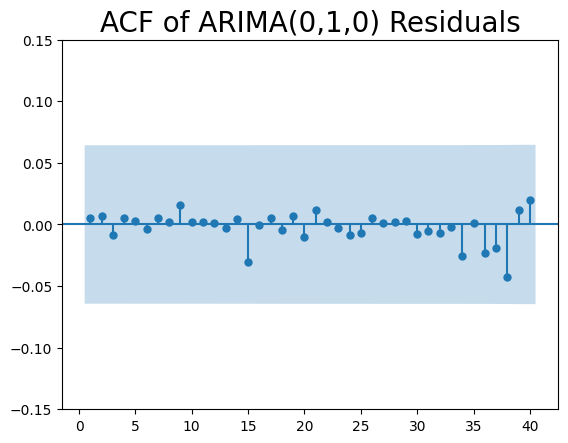

In [23]:
model_spx_010_res = results_model_spx_010.resid 

sgt.plot_acf(model_spx_010_res, zero=False, lags=40)
plt.title("ACF of ARIMA(0,1,0) Residuals", size=20)
plt.gca().set_ylim(-0.15, 0.15)
plt.show()

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
ljung_box_results = acorr_ljungbox(model_spx_010_res, lags=[10], return_df=True)

# Print the results
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.467093   0.999995


Using the Ljung-Box test, we see that there is no statistical evidence to reject H0, suggesting that there is no autocorrelation within our residuals - thus exhibiting white noise. This is what we want as we want to train our model to adapt to any type of data and not overfit our training dataset.

### Forecasting

In [25]:
print(df["SPX"].head())
print(df["SPX"].tail())

Date
2020-01-03    3226.360107
2020-01-06    3217.550049
2020-01-07    3241.860107
2020-01-08    3238.590088
2020-01-09    3266.030029
Name: SPX, dtype: float64
Date
2023-09-06    4490.350098
2023-09-07    4434.549805
2023-09-08    4451.299805
2023-09-11    4480.979980
2023-09-12    4473.270020
Name: SPX, dtype: float64


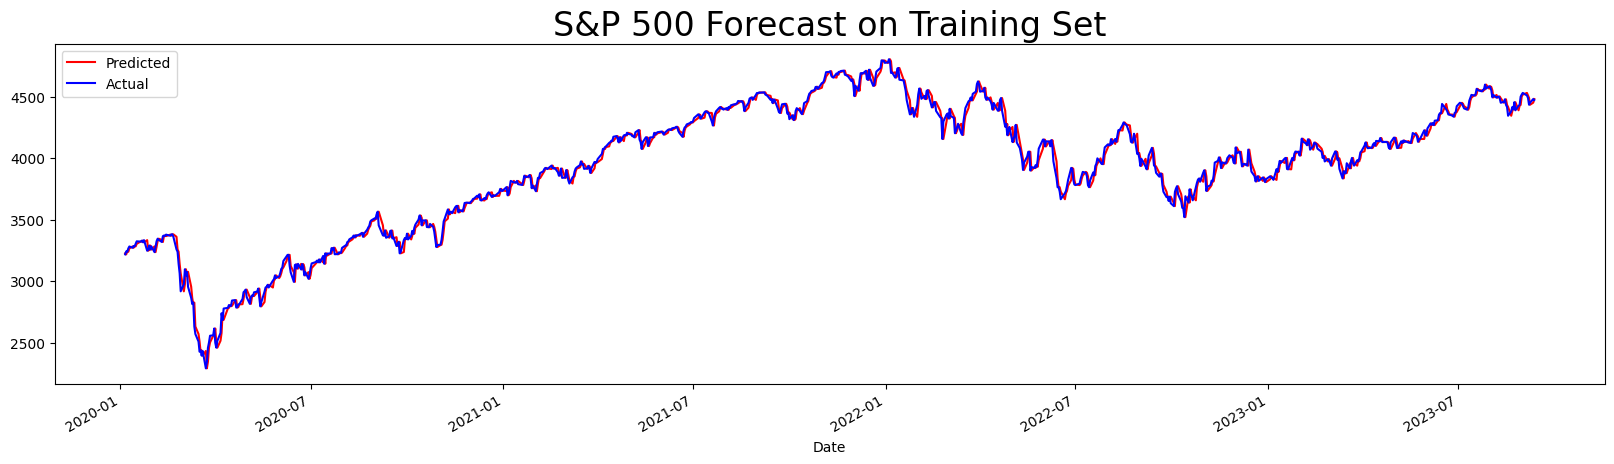

In [26]:
# State the start and end dates for the forecast
start_date = "2020-01-06"
end_date = "2023-09-12"

df_forecast = results_model_spx_010.predict(start=start_date, end=end_date)

df_forecast[start_date:end_date].plot(figsize=(20, 5), color="red", label='Predicted')
df['SPX'][start_date:end_date].plot(color="blue", label='Actual')
plt.title("S&P 500 Forecast on Training Set", size=24)
plt.legend()
plt.show()

In [27]:
# Ensure the predicted and actual values align
predicted = df_forecast[start_date:end_date]
actual = df['SPX'][start_date:end_date]

# Calculate Mean Absolute Percentage Error 
mape = (abs(predicted - actual) / actual).mean() * 100

# Calculate accuracy as (100% - MAPE)
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Prediction Accuracy: {accuracy:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.88%
Prediction Accuracy: 99.12%


How does our model work with the testing set?

In [28]:
print(df_test.head())
print(df_test.tail())

                 NDAQ          SPX
Date                              
2023-09-13  50.168331  4462.649902
2023-09-14  50.013269  4487.779785
2023-09-15  50.385260  4497.979980
2023-09-18  49.592334  4445.129883
2023-09-19  49.925168  4445.410156
                 NDAQ          SPX
Date                              
2025-04-10  70.629997  5353.149902
2025-04-11  69.980003  5255.560059
2025-04-14  72.519997  5441.959961
2025-04-15  72.949997  5411.990234
2025-04-16  72.440002  5335.750000


/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


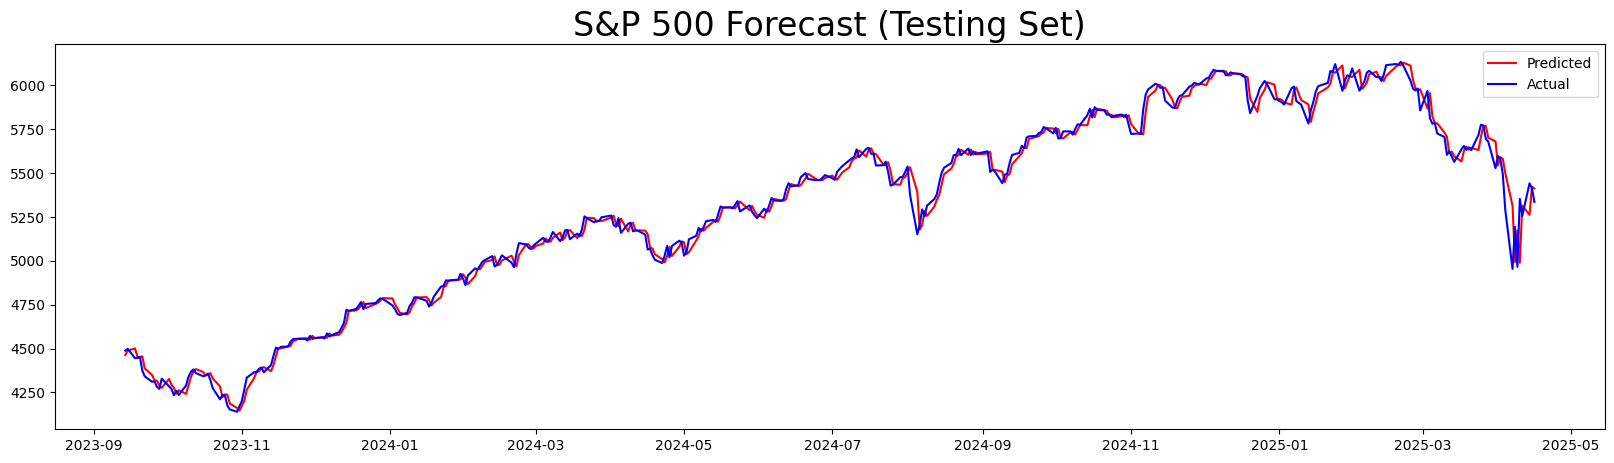

In [29]:
# Define test start and end dates
test_start_date = "2023-09-14"
test_end_date = "2025-04-16"

test_start_date_ts = pd.Timestamp(test_start_date)

df_test['SPX'] = pd.to_numeric(df_test['SPX'], errors='coerce')
df_test["SPX"].describe()

# Fit ARIMA model
test_model_spx_101 = ARIMA(df_test.SPX, order=(1,0,1))
test_results_model_spx_101 = test_model_spx_101.fit()

# Generate predictions at price level
pred_test_model_spx_101 = test_results_model_spx_101 .predict(start=test_start_date, end=test_end_date, typ='levels') 

# Find the last actual value before prediction starts
last_actual_value = df_test['SPX'].loc[test_start_date_ts - pd.Timedelta(days=1)]

# Fix the first predicted value to align with actual price
pred_test_model_spx_101.iloc[0] = last_actual_value

# Plot results
plt.figure(figsize=(20, 5))
plt.plot(pred_test_model_spx_101, color="red", label='Predicted')
plt.plot(df_test.SPX[test_start_date:test_end_date], color="blue", label='Actual')
plt.title("S&P 500 Forecast (Testing Set)", size=24)
plt.legend()
plt.show()

In [30]:
# Calculatibg MAPE accuracy for our testing set
predicted = pred_test_model_spx_101[test_start_date:test_end_date]
actual = df_test['SPX'][test_start_date:test_end_date]
mape = (abs(predicted - actual) / actual).mean() * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Prediction Accuracy: {accuracy:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.68%
Prediction Accuracy: 99.32%


### Predicting S&P 500 Prices

Remerge trainng and testing dataset for out-of-sample forecasts

In [31]:
df = pd.concat([df, df_test])
df.drop(["d.SPX"], axis=1, inplace=True)
df

,NDAQ,SPX
Date,,
2020-01-03,33.066199,3226.360107
2020-01-06,33.316549,3217.550049
2020-01-07,33.381469,3241.860107
2020-01-08,32.920921,3238.590088
2020-01-09,32.846738,3266.030029
...,...,...
2025-04-10,70.629997,5353.149902
2025-04-11,69.980003,5255.560059
2025-04-14,72.519997,5441.959961


/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python

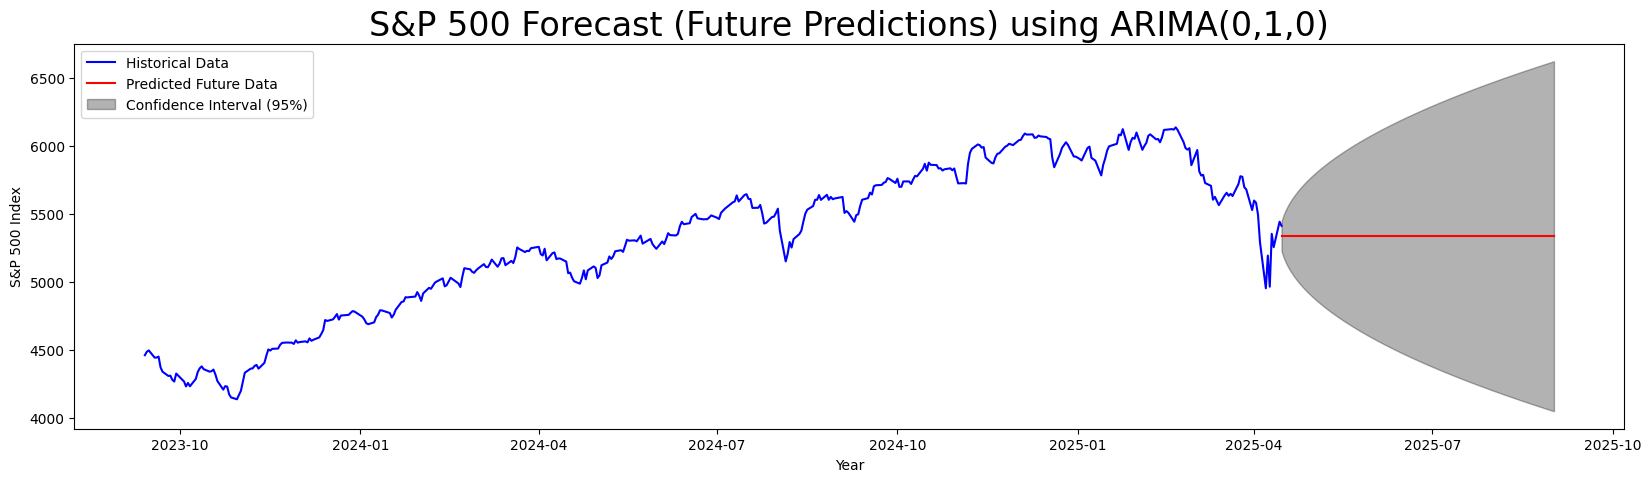

In [32]:
# Using ARIMA Model
# Prediction date range
predict_start_date = "2025-04-15"
predict_end_date = "2025-09-01"
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Fit the ARIMA model on the entire dataset
model_spx_010 = ARIMA(df_test['SPX'], order=(0,1,0))
results_model_spx_010 = model_spx_010.fit()

# Generate predictions for the future dates (beyond the dataset)
forecast = results_model_spx_010.get_forecast(steps=num_steps)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a date range for the future predictions
future_dates = pd.date_range(start=predict_start_date, end=predict_end_date, freq='D')

# Align the predictions with the future dates
future_predictions.index = future_dates

# Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_test.SPX[:predict_start_date], color="blue", label='Historical Data')
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='black', alpha=0.3, label='Confidence Interval (95%)')

plt.title("S&P 500 Forecast (Future Predictions) using ARIMA(0,1,0)", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

As we can see, when using a simple ARIMA model to predict future prices, there doesn't seem to be a very accurate indication of where prices will go. We will attempt to predict future prices by feeding our model with more context (i.e. exogeneous variables)

### Creating an ARIMAX model 

Federal Funds Effective Rate (Interest Rate): https://fred.stlouisfed.org/series/DFF

In [33]:
# Import downloaded data on interest rates
df2 = pd.read_csv('/Users/ivan/Documents/Data Science Projects/spx_price_forecast/Datasets/irate.csv')
print(df2.head())
print(df2.tail())

  observation_date   DFF
0       2020-01-01  1.55
1       2020-01-02  1.55
2       2020-01-03  1.55
3       2020-01-04  1.55
4       2020-01-05  1.55
     observation_date   DFF
1927       2025-04-11  4.33
1928       2025-04-12  4.33
1929       2025-04-13  4.33
1930       2025-04-14  4.33
1931       2025-04-15  4.33


In [34]:
df2.columns = ["Date", "interest"]  
df2 = df2.round(2)

print(df2.head())
print(df.head())

         Date  interest
0  2020-01-01      1.55
1  2020-01-02      1.55
2  2020-01-03      1.55
3  2020-01-04      1.55
4  2020-01-05      1.55
                 NDAQ          SPX
Date                              
2020-01-03  33.066199  3226.360107
2020-01-06  33.316549  3217.550049
2020-01-07  33.381469  3241.860107
2020-01-08  32.920921  3238.590088
2020-01-09  32.846738  3266.030029


We want the head and tail of our datasets to match (or at least the heads to match)

In [35]:
df2 = df2.drop([0, 1])  
df2 = df2.reset_index(drop=True)
df2.fillna(0)
print(df2.head(),df.head())

         Date  interest
0  2020-01-03      1.55
1  2020-01-04      1.55
2  2020-01-05      1.55
3  2020-01-06      1.55
4  2020-01-07      1.55                  NDAQ          SPX
Date                              
2020-01-03  33.066199  3226.360107
2020-01-06  33.316549  3217.550049
2020-01-07  33.381469  3241.860107
2020-01-08  32.920921  3238.590088
2020-01-09  32.846738  3266.030029


In [36]:
print(df2.tail(),df_test.tail())

            Date  interest
1925  2025-04-11      4.33
1926  2025-04-12      4.33
1927  2025-04-13      4.33
1928  2025-04-14      4.33
1929  2025-04-15      4.33                  NDAQ          SPX
Date                              
2025-04-10  70.629997  5353.149902
2025-04-11  69.980003  5255.560059
2025-04-14  72.519997  5441.959961
2025-04-15  72.949997  5411.990234
2025-04-16  72.440002  5335.750000


10-Year Breakeven Inflation Rate (Market Expectations): https://fred.stlouisfed.org/series/T10YIE

In [37]:
# Importing Inflation Rate data
df3 = pd.read_csv('/Users/ivan/Documents/Data Science Projects/spx_price_forecast/Datasets/inflation.csv')
df3.head()

,observation_date,T10YIE
0,16/04/2015,1.85
1,17/04/2015,1.89
2,20/04/2015,1.89
3,21/04/2015,1.86
4,22/04/2015,1.87


In [38]:
df3.columns = ["Date", "inflation"]
df3 = df3.round(2)

df3 = df3.drop(range(0, 1231))
df3 = df3.reset_index(drop=True)
df3.fillna(0)

print(df3.head(),df.head())

         Date  inflation
0  03/01/2020       1.77
1  06/01/2020       1.75
2  07/01/2020       1.74
3  08/01/2020       1.75
4  09/01/2020       1.74                  NDAQ          SPX
Date                              
2020-01-03  33.066199  3226.360107
2020-01-06  33.316549  3217.550049
2020-01-07  33.381469  3241.860107
2020-01-08  32.920921  3238.590088
2020-01-09  32.846738  3266.030029


In [39]:
print(df3.tail(),df_test.tail())

            Date  inflation
1374  10/04/2025       2.19
1375  11/04/2025       2.20
1376  14/04/2025       2.23
1377  15/04/2025       2.19
1378  16/04/2025       2.17                  NDAQ          SPX
Date                              
2025-04-10  70.629997  5353.149902
2025-04-11  69.980003  5255.560059
2025-04-14  72.519997  5441.959961
2025-04-15  72.949997  5411.990234
2025-04-16  72.440002  5335.750000


In [40]:
# Convert all Date columns to datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df3['Date'] = pd.to_datetime(df3['Date'], format='%d/%m/%Y') # The date format was given as date/month/year for this dataset

In [41]:
# Merge all three datasets together
df = df.merge(df2, on='Date').merge(df3, on='Date')
print(df.head())
print(df.tail())

        Date       NDAQ          SPX  interest  inflation
0 2020-01-03  33.066199  3226.360107      1.55       1.77
1 2020-01-06  33.316549  3217.550049      1.55       1.75
2 2020-01-07  33.381469  3241.860107      1.55       1.74
3 2020-01-08  32.920921  3238.590088      1.55       1.75
4 2020-01-09  32.846738  3266.030029      1.55       1.74
           Date       NDAQ          SPX  interest  inflation
1323 2025-04-09  66.120003  4965.279785      4.33       2.27
1324 2025-04-10  70.629997  5353.149902      4.33       2.19
1325 2025-04-11  69.980003  5255.560059      4.33       2.20
1326 2025-04-14  72.519997  5441.959961      4.33       2.23
1327 2025-04-15  72.949997  5411.990234      4.33       2.19


In [42]:
# Ensuring that there were no missing values in the dataset
print("NaN values:", df[["interest", "inflation"]].isna().sum())
print("Infinite values:", np.isinf(df[["interest", "inflation"]]).sum())

NaN values: interest     0
inflation    0
dtype: int64
Infinite values: interest     0
inflation    0
dtype: int64


We are now ready to predict future prices with our exogeneous variables

In [43]:
# Using an ARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Define the prediction date range
predict_start_date = "2025-04-15"  #Start prediction from the last date of historical data
predict_end_date = "2025-09-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

exog = df[["NDAQ", "interest", "inflation"]]

### First Prediction Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10777D+00    |proj g|=  7.49521D-04
  ys=-9.002E+00  -gs= 1.023E+00 BFGS update SKIPPED

At iterate    5    f=  5.01439D+00    |proj g|=  9.94840D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     19      2     1     0   9.948D-06   5.014D+00
  F =   5.0143906341329796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
=== Historical Performance (In-Sample) ===
           Date       Actual    Predi

 This problem is unconstrained.


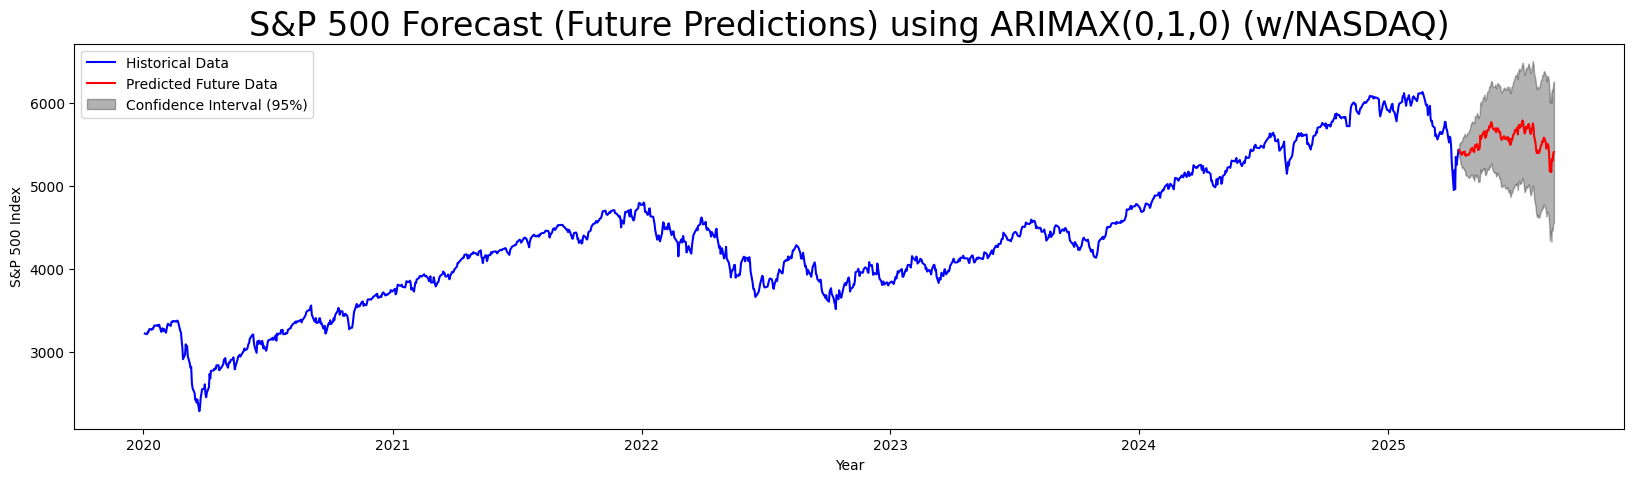

In [44]:
# Define the prediction date range
predict_start_date = "2025-04-15"  
predict_end_date = "2025-09-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Fit the SARIMAX model on the aligned dataset
model_spx_010_s = SARIMAX(df.SPX, exog=exog, order=(0, 1, 0))
results_model_spx_010_s = model_spx_010_s.fit()

# Get in-sample (historical) fitted values 
in_sample_pred = results_model_spx_010_s.get_prediction().predicted_mean

# Get out-of-sample (future) forecast 
# Generate future exogenous values
future_exog = exog.iloc[-num_steps:].copy()
if future_exog.shape[0] < num_steps:
    last_exog = exog.iloc[-1].values.reshape(1, -1)
    future_exog = pd.DataFrame(
        np.tile(last_exog, (num_steps, 1)),
        columns=exog.columns
    )

# Generate predictions for the future dates
forecast = results_model_spx_010_s.get_forecast(steps=num_steps, exog=future_exog)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create comparison tables 
# Historical values 
historical_comparison = pd.DataFrame({
    'Date': df['Date'],
    'Actual': df['SPX'],
    'Predicted': in_sample_pred,
    'Residual': df['SPX'] - in_sample_pred
})

# Future values
future_dates = pd.date_range(start=predict_start_date, periods=num_steps)
future_comparison = pd.DataFrame({
    'Date': future_dates,
    'Predicted': future_predictions,
    'Lower_CI': confidence_intervals.iloc[:, 0],
    'Upper_CI': confidence_intervals.iloc[:, 1]
})

# Print tables
print("=== Historical Performance (In-Sample) ===")
print(historical_comparison.tail(10).to_string())  
print("\n=== Future Forecast (Out-of-Sample) ===")
print(future_comparison.head(10).to_string())  

#Plot the results
future_predictions.index = future_dates

plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['SPX'], color="blue", label='Historical Data') 
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='black', alpha=0.3, label='Confidence Interval (95%)')
plt.title("S&P 500 Forecast (Future Predictions) using ARIMAX(0,1,0) (w/NASDAQ)", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

In [45]:
# Correlation matrix between the variables
print(df[['SPX','NDAQ', 'interest', 'inflation']].corr())  

                SPX      NDAQ  interest  inflation
SPX        1.000000  0.895569  0.592017   0.523889
NDAQ       0.895569  1.000000  0.470509   0.561250
interest   0.592017  0.470509  1.000000   0.225451
inflation  0.523889  0.561250  0.225451   1.000000


- We figure that only including NASDAQ as an exog variable may cause a multicollinearity issue (due to SPX and NDAQ being too highly correlated to one another), so we decide to include additional variables to see if it helps improve our forecast. <br><br>
- Could perform a Granger-Causality test to determine if NASDAQ 'Granger' causes S&P 500: there will most likely be a bi-directional found.

Sources: <br>
https://finance.yahoo.com/quote/BZ=F/<br>
https://finance.yahoo.com/quote/%5EVIX/

In [46]:
# Import VIX (Volatility Index) and Crude Oil prices
tickers = ["^VIX", "BZ=F"]
start_date = "2020-01-01"
end_date = "2025-04-17"

data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv('/Users/ivan/Documents/Data Science Projects/spx_price_forecast/Datasets/index.csv')
df2 = pd.read_csv('/Users/ivan/Documents/Data Science Projects/spx_price_forecast/Datasets/index.csv')

[*********************100%***********************]  2 of 2 completed


In [47]:
# Cleaning data like previously
columns_to_drop = (
    [f"{prefix}{i}" for prefix in ["Close.", "High.", "Volume.", "Low."] for i in range(1, 2)]
)
df2.drop(columns_to_drop, axis=1, inplace=True)

df2.drop(["Close", "High", "Volume", "Low"], axis=1, inplace=True)

In [48]:
df2.head()

,Price,Open,Open.1
0,Ticker,BZ=F,^VIX
1,Date,NaN,NaN
2,2020-01-02,66.47000122070312,13.460000038146973
3,2020-01-03,66.29000091552734,15.010000228881836
4,2020-01-06,69.06999969482422,15.449999809265137


In [49]:
df2.columns = ["Date", "crude", "VIX"]  
df2 = df2[df2["Date"] != "NaN"]  

df2 = df2.drop([0, 1])  
df2 = df2.iloc[1:]
df2 = df2.reset_index(drop=True)

In [50]:
df2["Date"] = pd.to_datetime(df2["Date"])  
df2.set_index("Date", inplace=True)  

In [51]:
df2.head()

,crude,VIX
Date,,
2020-01-03,66.29000091552734,15.010000228881836
2020-01-06,69.06999969482422,15.449999809265137
2020-01-07,68.58000183105469,13.84000015258789
2020-01-08,68.47000122070312,15.15999984741211
2020-01-09,65.79000091552734,12.949999809265137


In [52]:
df2["crude"] = pd.to_numeric(df2["crude"], errors='coerce')
df2["VIX"] = pd.to_numeric(df2["VIX"], errors='coerce')

df.head()

,Date,NDAQ,SPX,interest,inflation
0,2020-01-03,33.066199,3226.360107,1.55,1.77
1,2020-01-06,33.316549,3217.550049,1.55,1.75
2,2020-01-07,33.381469,3241.860107,1.55,1.74
3,2020-01-08,32.920921,3238.590088,1.55,1.75
4,2020-01-09,32.846738,3266.030029,1.55,1.74


In [53]:
df = df.merge(df2, on='Date')
print(df.head())

        Date       NDAQ          SPX  interest  inflation      crude    VIX
0 2020-01-03  33.066199  3226.360107      1.55       1.77  66.290001  15.01
1 2020-01-06  33.316549  3217.550049      1.55       1.75  69.070000  15.45
2 2020-01-07  33.381469  3241.860107      1.55       1.74  68.580002  13.84
3 2020-01-08  32.920921  3238.590088      1.55       1.75  68.470001  15.16
4 2020-01-09  32.846738  3266.030029      1.55       1.74  65.790001  12.95


In [54]:
# Using an ARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Define the prediction date range
predict_start_date = "2025-04-15"  
predict_end_date = "2025-09-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Re-defining our exogeneous variables list 
exog = df[["NDAQ", "interest", "inflation", "crude", "VIX"]]

In [55]:
# Checking correlation matrix to ensure we don't make the same mistake as before (with multicollinearity issue)
print(df[['SPX', 'interest', 'inflation', 'crude', 'VIX']].corr())

                SPX  interest  inflation     crude       VIX
SPX        1.000000  0.592017   0.523889  0.440482 -0.585297
interest   0.592017  1.000000   0.225451  0.364569 -0.468693
inflation  0.523889  0.225451   1.000000  0.790462 -0.454353
crude      0.440482  0.364569   0.790462  1.000000 -0.352959
VIX       -0.585297 -0.468693  -0.454353 -0.352959  1.000000


In [56]:
# Re-evaluate optimal lags for new ARIMAX model
import pmdarima as pm
import pandas as pd

# Function to find the best ARIMAX order using different information criteria
def find_best_arimax_order(series, exogenous, max_lags, criterion):
    model = pm.auto_arima(
        series,
        exogenous=exog, 
        start_p=0, start_q=0,
        max_p=max_lags, max_q=max_lags,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        information_criterion=criterion,
    )
    return model.order

# Find the best ARIMAX order for SPX using AIC, BIC, and HQIC
spx_orders = {
    'AIC': find_best_arimax_order(df['SPX'], df[['NDAQ', 'interest', 'inflation', 'crude', 'VIX']], max_lags, 'aic'),
    'BIC': find_best_arimax_order(df['SPX'], df[['NDAQ', 'interest', 'inflation', 'crude', 'VIX']], max_lags, 'bic'),
    'HQIC': find_best_arimax_order(df['SPX'], df[['NDAQ', 'interest', 'inflation', 'crude', 'VIX']], max_lags, 'hqic')
}

# Print the selected ARIMAX orders
for criterion, order in spx_orders.items():
    print(f'Selected ARIMAX order for SPX using {criterion}: {order}')

/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warning

Selected ARIMAX order for SPX using AIC: (4, 1, 2)
Selected ARIMAX order for SPX using BIC: (0, 1, 0)
Selected ARIMAX order for SPX using HQIC: (0, 1, 0)


We find that there is a conflict between two models, an ARIMAX(4,1,2) and an ARIMAX(0,1,0). We will proceed to analyse both models.

ARIMA(0,1,0) Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91454D+00    |proj g|=  9.09430D-04


 This problem is unconstrained.



At iterate    5    f=  4.82127D+00    |proj g|=  6.92448D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     23      1     0     0   3.069D-06   4.821D+00
  F =   4.8211522372180999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
=== Historical Performance (In-Sample) ===
           Date       Actual    Predicted    Residual
1318 2025-04-02  5580.759766  5594.038728  -13.278962
1319 2025-04-03  5492.740234  5524.650565  -31.910331
1320 2025-04-04  5292.140137  5373.193094  -81.052957
1321 2025-04-07  4953.790039  4878.068358   75.721681
1322 2025-04-08  5193.569824  5177.785269   15.7

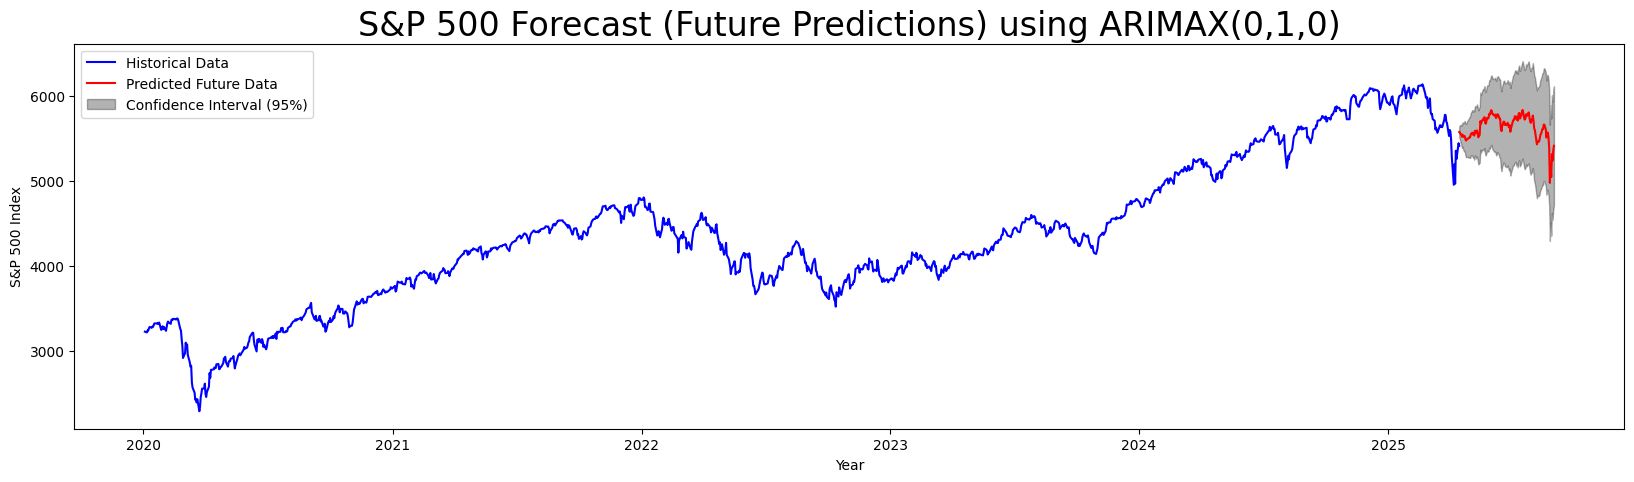

In [57]:
# Using an ARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the prediction date range
predict_start_date = "2025-04-15"  
predict_end_date = "2025-09-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Fit the SARIMAX model on the aligned dataset
model_spx_010_s = SARIMAX(df.SPX, exog=exog, order=(0, 1, 0))
results_model_spx_010_s = model_spx_010_s.fit()

# Get in-sample (historical) fitted values 
in_sample_pred = results_model_spx_010_s.get_prediction().predicted_mean

# Get out-of-sample (future) forecast 
# Generate future exogenous values
future_exog = exog.iloc[-num_steps:].copy()
if future_exog.shape[0] < num_steps:
    last_exog = exog.iloc[-1].values.reshape(1, -1)
    future_exog = pd.DataFrame(
        np.tile(last_exog, (num_steps, 1)),
        columns=exog.columns
    )

# Generate predictions for the future dates
forecast = results_model_spx_010_s.get_forecast(steps=num_steps, exog=future_exog)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create comparison tables 
# Historical comparison (actual vs fitted)
historical_comparison = pd.DataFrame({
    'Date': df['Date'],
    'Actual': df['SPX'],
    'Predicted': in_sample_pred,
    'Residual': df['SPX'] - in_sample_pred
})

# Future predictions
future_dates = pd.date_range(start=predict_start_date, periods=num_steps)
future_comparison = pd.DataFrame({
    'Date': future_dates,
    'Predicted': future_predictions,
    'Lower_CI': confidence_intervals.iloc[:, 0],
    'Upper_CI': confidence_intervals.iloc[:, 1]
})

# Print tables
print("=== Historical Performance (In-Sample) ===")
print(historical_comparison.tail(10).to_string())  # Show last 10 observations

print("\n=== Future Forecast (Out-of-Sample) ===")
print(future_comparison.head(10).to_string())  # Show first 10 forecasts

# Plot the results
future_predictions.index = future_dates

plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['SPX'], color="blue", label='Historical Data') 
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='black', alpha=0.3, label='Confidence Interval (95%)')
plt.title("S&P 500 Forecast (Future Predictions) using ARIMAX(0,1,0)", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

ARIMA(4,1,2) Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81634D+00    |proj g|=  3.77687D-03


 This problem is unconstrained.



At iterate    5    f=  4.81611D+00    |proj g|=  9.06352D-03

At iterate   10    f=  4.81583D+00    |proj g|=  4.28974D-04

At iterate   15    f=  4.81579D+00    |proj g|=  3.08264D-03

At iterate   20    f=  4.81575D+00    |proj g|=  3.57167D-04

At iterate   25    f=  4.81573D+00    |proj g|=  7.34433D-04

At iterate   30    f=  4.81573D+00    |proj g|=  4.00433D-04

At iterate   35    f=  4.81573D+00    |proj g|=  7.18848D-04

At iterate   40    f=  4.81572D+00    |proj g|=  4.02421D-05

At iterate   45    f=  4.81572D+00    |proj g|=  1.31980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     47     53   

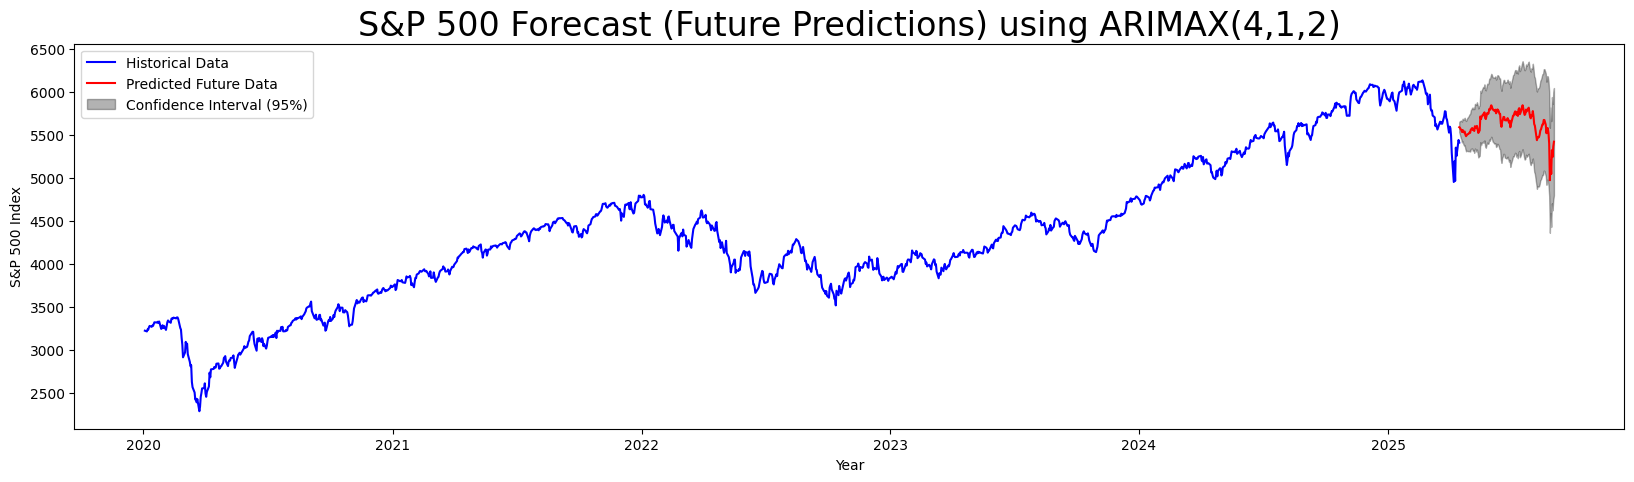

In [58]:
# Using an ARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the prediction date range
predict_start_date = "2025-04-15"  
predict_end_date = "2025-09-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Fit the SARIMAX model on the aligned dataset
model_spx_010_s = SARIMAX(df.SPX, exog=exog, order=(4, 1, 2))
results_model_spx_010_s = model_spx_010_s.fit()

# Get in-sample (historical) fitted values 
in_sample_pred = results_model_spx_010_s.get_prediction().predicted_mean

# Get out-of-sample (future) forecast 
# Generate future exogenous values
future_exog = exog.iloc[-num_steps:].copy()
if future_exog.shape[0] < num_steps:
    last_exog = exog.iloc[-1].values.reshape(1, -1)
    future_exog = pd.DataFrame(
        np.tile(last_exog, (num_steps, 1)),
        columns=exog.columns
    )

# Generate predictions for the future dates
forecast = results_model_spx_010_s.get_forecast(steps=num_steps, exog=future_exog)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# 3. Create comparison tables 
# Historical comparison (actual vs fitted)
historical_comparison = pd.DataFrame({
    'Date': df['Date'],
    'Actual': df['SPX'],
    'Predicted': in_sample_pred,
    'Residual': df['SPX'] - in_sample_pred
})

# Future predictions
future_dates = pd.date_range(start=predict_start_date, periods=num_steps)
future_comparison = pd.DataFrame({
    'Date': future_dates,
    'Predicted': future_predictions,
    'Lower_CI': confidence_intervals.iloc[:, 0],
    'Upper_CI': confidence_intervals.iloc[:, 1]
})

# Print tables
print("=== Historical Performance (In-Sample) ===")
print(historical_comparison.tail(10).to_string())  # Show last 10 observations

print("\n=== Future Forecast (Out-of-Sample) ===")
print(future_comparison.head(10).to_string())  # Show first 10 forecasts

# Plot the results
future_predictions.index = future_dates

plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['SPX'], color="blue", label='Historical Data') 
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='black', alpha=0.3, label='Confidence Interval (95%)')
plt.title("S&P 500 Forecast (Future Predictions) using ARIMAX(4,1,2)", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

We can also analyse what will happen if we attempt to capture the impact of a volatility spike (by using VIX^2)

In [59]:
df["VIX^2"] = df["VIX"]**2 
df.head()

,Date,NDAQ,SPX,interest,inflation,crude,VIX,VIX^2
0,2020-01-03,33.066199,3226.360107,1.55,1.77,66.290001,15.01,225.300107
1,2020-01-06,33.316549,3217.550049,1.55,1.75,69.070000,15.45,238.702494
2,2020-01-07,33.381469,3241.860107,1.55,1.74,68.580002,13.84,191.545604
3,2020-01-08,32.920921,3238.590088,1.55,1.75,68.470001,15.16,229.825595
4,2020-01-09,32.846738,3266.030029,1.55,1.74,65.790001,12.95,167.702495


/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77175D+00    |proj g|=  1.05768D-01

At iterate    5    f=  4.76596D+00    |proj g|=  6.41075D-04

At iterate   10    f=  4.76592D+00    |proj g|=  6.30726D-03

At iterate   15    f=  4.76576D+00    |proj g|=  6.88126D-03

At iterate   20    f=  4.76574D+00    |proj g|=  3.91397D-03

At iterate   25    f=  4.76573D+00    |proj g|=  1.79372D-04

At iterate   30    f=  4.76572D+00    |proj g|=  4.22818D-03

At iterate   35    f=  4.76570D+00    |proj g|=  2.58637D-04

At iterate   40    f=  4.76570D+00    |proj g|=  1.12912D-04

At iterate   45    f=  4.76570D+00    |proj g|=  4.51555D-04

At iterate   50    f=  4.76570D+00    |proj g|=  1.08886D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


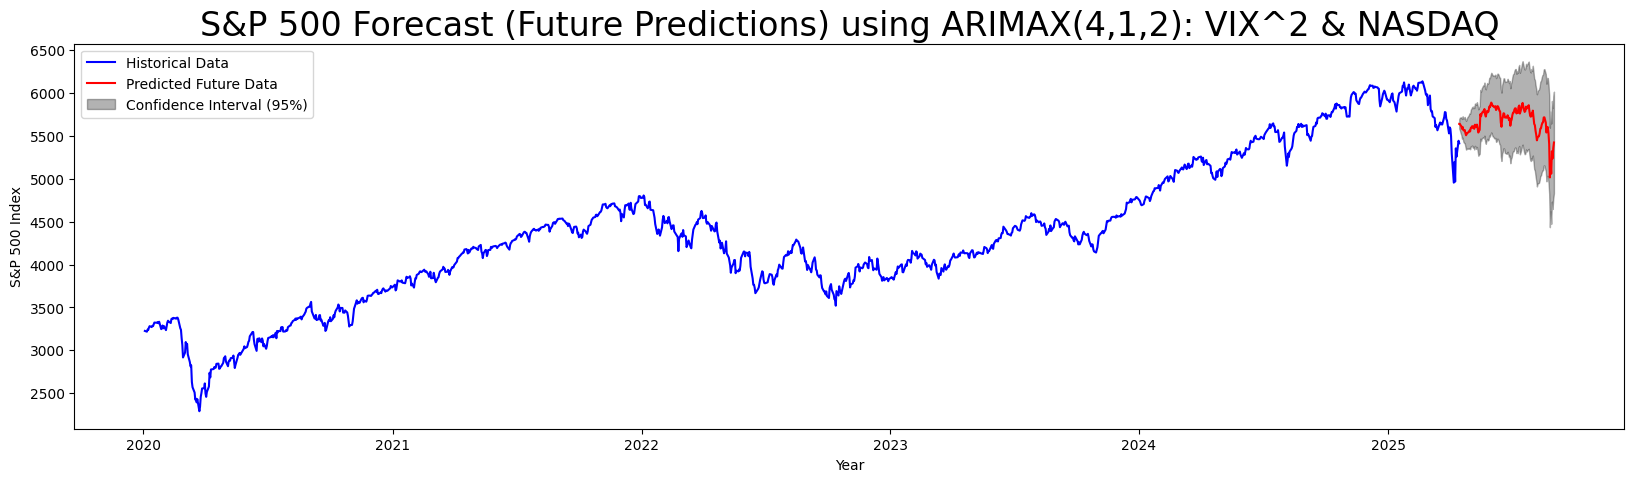

In [60]:
# Including VIX^2 in our exogeneous variables list
exog = df[["NDAQ", "interest", "inflation", "crude", "VIX", "VIX^2"]]

# Using an ARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the prediction date range
predict_start_date = "2025-04-15"  
predict_end_date = "2025-09-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Fit the SARIMAX model on the aligned dataset
model_spx_010_s = SARIMAX(df.SPX, exog=exog, order=(4, 1, 2))
results_model_spx_010_s = model_spx_010_s.fit()

# Get in-sample (historical) fitted values 
in_sample_pred = results_model_spx_010_s.get_prediction().predicted_mean

# Get out-of-sample (future) forecast 
# Generate future exogenous values
future_exog = exog.iloc[-num_steps:].copy()
if future_exog.shape[0] < num_steps:
    last_exog = exog.iloc[-1].values.reshape(1, -1)
    future_exog = pd.DataFrame(
        np.tile(last_exog, (num_steps, 1)),
        columns=exog.columns
    )

# Generate predictions for the future dates
forecast = results_model_spx_010_s.get_forecast(steps=num_steps, exog=future_exog)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create comparison tables 
# Historical comparison (actual vs fitted)
historical_comparison = pd.DataFrame({
    'Date': df['Date'],
    'Actual': df['SPX'],
    'Predicted': in_sample_pred,
    'Residual': df['SPX'] - in_sample_pred
})

# Future predictions
future_dates = pd.date_range(start=predict_start_date, periods=num_steps)
future_comparison = pd.DataFrame({
    'Date': future_dates,
    'Predicted': future_predictions,
    'Lower_CI': confidence_intervals.iloc[:, 0],
    'Upper_CI': confidence_intervals.iloc[:, 1]
})

# Print tables
print("=== Historical Performance (In-Sample) ===")
print(historical_comparison.tail(10).to_string())  # Show last 10 observations

print("\n=== Future Forecast (Out-of-Sample) ===")
print(future_comparison.head(10).to_string())  # Show first 10 forecasts

# Plot the results
future_predictions.index = future_dates

plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['SPX'], color="blue", label='Historical Data') 
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='black', alpha=0.3, label='Confidence Interval (95%)')
plt.title("S&P 500 Forecast (Future Predictions) using ARIMAX(4,1,2): VIX^2 & NASDAQ", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93414D+00    |proj g|=  1.10378D-01

At iterate    5    f=  4.93380D+00    |proj g|=  4.05980D-03

At iterate   10    f=  4.93379D+00    |proj g|=  1.52290D-03

At iterate   15    f=  4.93378D+00    |proj g|=  5.61700D-03

At iterate   20    f=  4.93333D+00    |proj g|=  3.07301D-02

At iterate   25    f=  4.93322D+00    |proj g|=  8.15281D-04

At iterate   30    f=  4.93312D+00    |proj g|=  6.38396D-03

At iterate   35    f=  4.93301D+00    |proj g|=  4.89214D-03

At iterate   40    f=  4.93301D+00    |proj g|=  2.70744D-03

At iterate   45    f=  4.93298D+00    |proj g|=  7.84636D-03

At iterate   50    f=  4.93291D+00    |proj g|=  1.11323D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/ivan/Documents/Data Science Projects/spx_price_forecast/arima/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


=== Historical Performance (In-Sample) ===
           Date       Actual    Predicted    Residual
1318 2025-04-02  5580.759766  5588.507094   -7.747328
1319 2025-04-03  5492.740234  5505.915888  -13.175654
1320 2025-04-04  5292.140137  5425.859868 -133.719731
1321 2025-04-07  4953.790039  4958.678334   -4.888295
1322 2025-04-08  5193.569824  5096.936204   96.633621
1323 2025-04-09  4965.279785  5098.231953 -132.952168
1324 2025-04-10  5353.149902  5199.724793  153.425110
1325 2025-04-11  5255.560059  5234.943301   20.616758
1326 2025-04-14  5441.959961  5337.100247  104.859714
1327 2025-04-15  5411.990234  5508.790030  -96.799796

=== Future Forecast (Out-of-Sample) ===
           Date    Predicted     Lower_CI     Upper_CI
1328 2025-04-15  5696.249537  5630.131135  5762.367939
1329 2025-04-16  5697.852917  5610.965636  5784.740198
1330 2025-04-17  5710.132717  5605.688488  5814.576947
1331 2025-04-18  5693.546216  5573.554083  5813.538350
1332 2025-04-19  5666.371604  5533.344704  5799

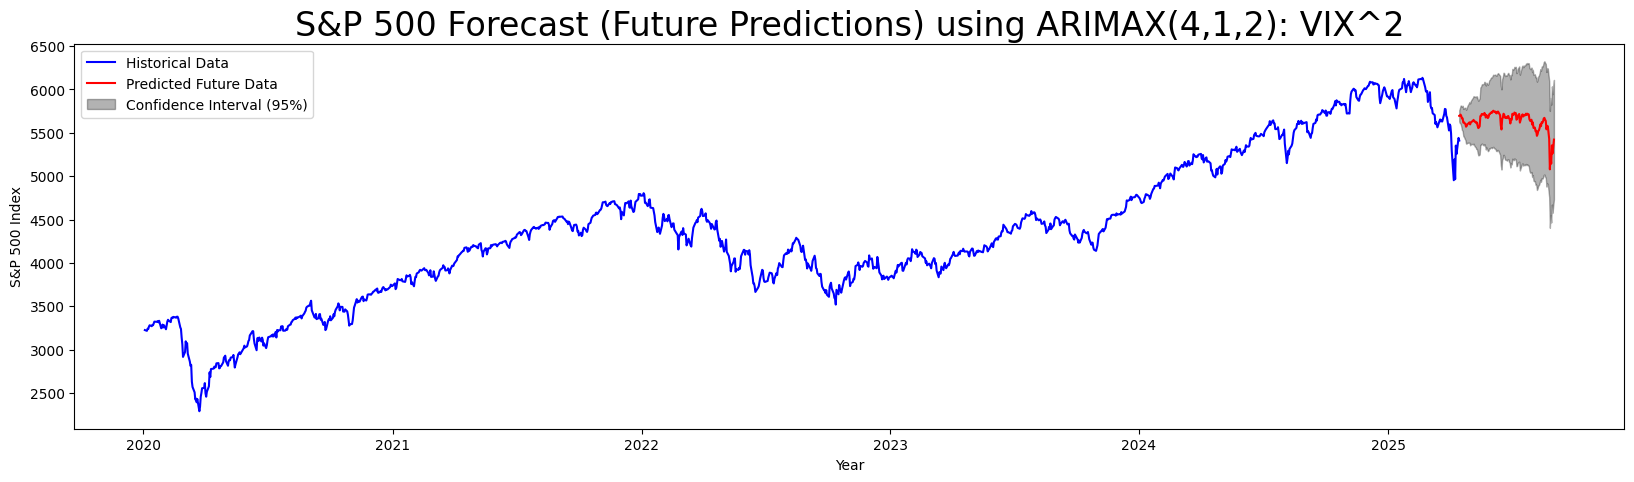

In [61]:
# Including VIX^2 in our exogeneous variables list
exog = df[["interest", "inflation", "crude", "VIX", "VIX^2"]]

# Using an ARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the prediction date range
predict_start_date = "2025-04-15"  
predict_end_date = "2025-09-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Fit the SARIMAX model on the aligned dataset
model_spx_010_s = SARIMAX(df.SPX, exog=exog, order=(4, 1, 2))
results_model_spx_010_s = model_spx_010_s.fit()

# Get in-sample (historical) fitted values 
in_sample_pred = results_model_spx_010_s.get_prediction().predicted_mean

# Get out-of-sample (future) forecast 
# Generate future exogenous values
future_exog = exog.iloc[-num_steps:].copy()
if future_exog.shape[0] < num_steps:
    last_exog = exog.iloc[-1].values.reshape(1, -1)
    future_exog = pd.DataFrame(
        np.tile(last_exog, (num_steps, 1)),
        columns=exog.columns
    )

# Generate predictions for the future dates
forecast = results_model_spx_010_s.get_forecast(steps=num_steps, exog=future_exog)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create comparison tables 
# Historical comparison (actual vs fitted)
historical_comparison = pd.DataFrame({
    'Date': df['Date'],
    'Actual': df['SPX'],
    'Predicted': in_sample_pred,
    'Residual': df['SPX'] - in_sample_pred
})

# Future predictions
future_dates = pd.date_range(start=predict_start_date, periods=num_steps)
future_comparison = pd.DataFrame({
    'Date': future_dates,
    'Predicted': future_predictions,
    'Lower_CI': confidence_intervals.iloc[:, 0],
    'Upper_CI': confidence_intervals.iloc[:, 1]
})

# Print tables
print("=== Historical Performance (In-Sample) ===")
print(historical_comparison.tail(10).to_string())  # Show last 10 observations

print("\n=== Future Forecast (Out-of-Sample) ===")
print(future_comparison.head(10).to_string())  # Show first 10 forecasts

# Plot the results
future_predictions.index = future_dates

plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['SPX'], color="blue", label='Historical Data') 
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='black', alpha=0.3, label='Confidence Interval (95%)')
plt.title("S&P 500 Forecast (Future Predictions) using ARIMAX(4,1,2): VIX^2", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

We find that our original ARIMA model lacked clarity for developing accurate price predictions of the S&P 500, so we attempt to include various exogeneous variables to get a better estimation. <br>
As seen above, we have made a major improvement, however, our model still lacks to account for larger spikes and ambiguity that is happening during the time of this analysis. <br>
For example, our model struggles to capture instanteneous policy changes and qualitative events (such as Trump's tariffs) which may only impact investors for a short-term. <br> 
Overall, our model is able to follow the pattern of historical well, but may struggle to adapt to environments of high volatility.

### Limitations and Improvements to the model: <br>
* Forecast VIX and crude endogeneously by using a VAR (Vector Auto Regressive) Model
* Large spikes in prices may not be captured [qualitative/semantic factors, such as geopolitical tensions and ambiguity of tariffs]
* Model a GARCH (Generalised Auto-Regressive Conditional Heteroskedasticity) model to capture movements in volatility movement